# **Lecture: Logistic Regression using Gradient Descent** (Liver Data Set)

https://www.kaggle.com/uciml/indian-liver-patient-records

In [1]:
import numpy as np # Numpy
import pandas as pd # Pandas is a great tool for working with and displaying data.
import matplotlib.pyplot as plt # For plotting.

In [15]:
# Data Prep Step for liver set.
#RAW_DATA = np.genfromtxt("~/Data/healthcare/liver", delimiter=',')
RAW_DATA_FRAME = pd.read_csv("~/Files/Data/Liver/indian_liver_patient.csv", header = None)
RAW_DATA_FRAME = RAW_DATA_FRAME.iloc[1:] # Remove the 0 row.

# Give the columns keywords.
Colnames = ['AGE', 'Sex', 'TOTAL_BIL', 'DIR_BIL', 'ALK_PHO', 'ALA_AMINO', 'ASP_AMI', 'TOTAL_PROT', 'ALBU', 'ALBU_GLO', 'DATA']
RAW_DATA_FRAME.columns = Colnames 

# Make an index for the included genders.
mapping = {'Female': 1, 'Male': 2}

# Map Female to 1 and Male to 2.
RAW_DATA_FRAME["Sex"] = [mapping[item] for item in RAW_DATA_FRAME["Sex"]]

# Make all the entries in the dataframe into floats. (They were read in as strings.)
cols = RAW_DATA_FRAME.columns
for col in cols:
    RAW_DATA_FRAME[col] = RAW_DATA_FRAME[col].astype(float)

# Print a small part of the data.
RAW_DATA_FRAME.head()

,AGE,Sex,TOTAL_BIL,DIR_BIL,ALK_PHO,ALA_AMINO,ASP_AMI,TOTAL_PROT,ALBU,ALBU_GLO,DATA
1,65.0,1.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1.0
2,62.0,2.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1.0
3,62.0,2.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1.0
4,58.0,2.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1.0
5,72.0,2.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1.0


In [14]:
np.unique(RAW_DATA_FRAME["DATA"], return_counts= True)

(array([1., 2.]), array([416, 167]))

This next block is for when we switch the the Iris set.  

---

### **Working to make training and testing data** 

---

This next section of code allows us to plot different features with respect to each other. For this method of machine learning we are looking for a linear correlation.

In [16]:
ALL_DATA_LABELS = ["ALBU", "TOTAL_BIL", "DIR_BIL", "ALA_AMINO","AGE","ALK_PHO","ASP_AMI", "DATA"]

In [19]:
ALL_DATA_SHUFFLED = RAW_DATA_FRAME[ALL_DATA_LABELS].sample(frac=1) # Shuffle the data frame
TRAINING = ALL_DATA_SHUFFLED[:400] # Build the training.
TESTING = ALL_DATA_SHUFFLED[400:] # Build the testing set.

In [20]:
TESTING.head()

,ALBU,TOTAL_BIL,DIR_BIL,ALA_AMINO,AGE,ALK_PHO,ASP_AMI,DATA
16,2.3,0.6,0.1,91.0,25.0,183.0,53.0,2.0
250,3.0,1.2,0.3,28.0,33.0,498.0,25.0,1.0
350,3.6,0.8,0.2,19.0,49.0,158.0,15.0,2.0
74,3.6,0.6,0.1,22.0,52.0,171.0,16.0,1.0
446,4.0,0.9,0.2,40.0,17.0,279.0,46.0,2.0


In [27]:
X_TRAIN =  np.array(TRAINING.drop("DATA",  axis=1)) # Remove the target column
Y_TRAIN = np.array(TRAINING["DATA"] - 1) # Change the targets to 0 and 1.

In [31]:
X_TEST = np.array(TESTING.drop("DATA",  axis=1))
Y_TEST = np.array(TESTING["DATA"] - 1)

### **Logistic Regression with Gradient Descent**

**The Goal: Find a line that best fits the data.**

---
First recall that the equation of the sigmoid is:
$$ \textrm{Sigmoid function:} \ \ S(x) = \frac{1}{1 + e^{-x}} $$  
$$ \textrm{Sigmoid function's Derivative:} \ \ S'(x) = S(x)(1 - S(x)) $$  

Now, each data value will be written as,
$$z = b + w_1 x_1 + w_2 x_2 + ... + w_m x_m = b +  \mathbf{W}^{T} \cdot \mathbf{X}   $$  
If we take this value, and evaluate it in the sigmoid, we will get a value between 0 and 1. So,
$$S(z) = \frac{1}{1 + e^{-z}} $$

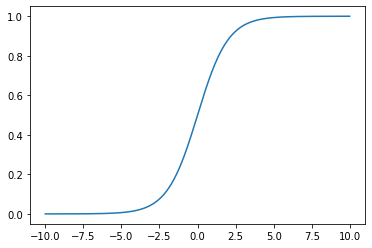

In [32]:
def S(z):
    return 1 / (1 + np.exp(-z))

t = np.arange(-10,10, .01)
plt.plot(t,S(t))
plt.show()

So, we are going to use gradient decent to find the best values for $b ,w_1,w_2...w_m$.  
There is one more thing that we will need. Since the idea here is to output information for a binary situation, we need to make sure that our target data is 0 or 1. We did this above in the data prep step.
$$\hat{y} = \begin{cases} 
      0 & y_i \ \ \textbf{is positive} \\
      1 & y_i \ \ \textbf{is negative}
   \end{cases} $$

The cost function that we want to minimize is:
$$ CE(b,w_1,w_2...w_m) = -\frac{1}{N}\sum_{i=1}^{N}\hat{y}_{i} \log(S(z)) + (1 - \hat{y}_{i}) \log(1 - S(z)) $$

### **Compute the Gradient:**  
The following is the notation that we will need to write down this important function. Since everything that we will be working with from here on out will have multiple feature vectors, we are going to be using gradient as the derivative we will be considering.

So, let's compute this object:  
$$\nabla CE(b,w_1,w_2...w_m) = \left\langle \frac{1}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) , \frac{x_1}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) , \frac{x_2}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) , ... , \frac{x_m}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) \right\rangle $$  

So to apply gradient descent we need to evaluate this vector over and over as we update the weights,
$$ \langle b, w_1, w_2, w_3, ... ,w_m \rangle - \left\langle \frac{1}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) , \frac{x_1}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) , \frac{x_2}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) , ... , \frac{x_m}{N} \sum_{i=1}^N (S(z) - \hat{y}_i) \right\rangle $$  


---

### **The Code**

$$S(z) = \frac{1}{1 + e^{-z}} $$  

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [34]:
def makegradient(X, Y, weights):
    Y = np.array(Y) # Make the target a numpy array.
    N  = len(X) # Assign the working length.
    
    # Make the linear z values.
    z = (weights *  X).sum(axis=1)    
     
    # Apply the sigmoid.
    Squshed_Z = sigmoid(z)
    
    # Make the gradients.
    B = np.dot(np.ones((len(Y),1)).T, Squshed_Z - Y) / N
    S = np.dot(X.T, Squshed_Z - Y) / N
    
    return [S , B] # Return the list.

In [35]:
def gradientDescentLogisticRegression(x, Y, learning_Rate, epochs):
        
    total_data = len(Y) # This is the N from above.
    weights = np.zeros(len(x.T)) # Random weights for our slope and intercept.
    B_VAL = np.zeros(1)
    
    # Loop over all the epochs.
    for i in range(epochs):
        
        # Find the gradients.
        grad = makegradient(x, Y, weights)
        
        # Update the weights.
        weights = weights - learning_Rate * grad[0]
        print(grad[0])
        B_VAL = B_VAL - learning_Rate * grad[1]

    
    # Return the weights, the list of intercepts and the list of slopes.
    return [weights, B_VAL]

In [36]:
w, b = gradientDescentLogisticRegression(X_TRAIN, Y_TRAIN, .1, 100) # Call the definition with our data sets.
print("The weights are: ",  w, "with a b value of: ", b)

[ 0.595625  1.1285    0.569375 34.80375  10.01625  81.99625  47.36375 ]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[  2.01229793   2.22444798   1.07988545  39.92437641  29.99006258
 213.85541804  52.67541847]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[  1.73252561   1.56231128   0.76152043  25.81163417  26.3016082
 188.88727878  31.55189314]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]
[  1.86275      1.84875      0.909       29.2949999   27.91249996
 198.34999978  37.87999983]
[ -0.97575  -0.35575  -0.1265   -9.2     -12.165   -65.2375  -11.38   ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [37]:
from sklearn.metrics import accuracy_score
V = [] # Empty list to collect the predictions.

x = np.array(X_TEST) # Assign the testing data.
y = np.array(Y_TEST) # Assign the testing targets.

# Loop over all the testing features to get the classification probabilities.
for i in range(len(x)):
    V.append(sigmoid(np.dot(w, x[i]) + b))

new_y_pred = [] # Empty list for the predictions.

# Set the tolerance to 50%.
for val in V:
    if(val >= 0.5):
        new_y_pred.append(1)
    else:
        new_y_pred.append(0)    

# Print the findings. (I use sklearn to help with counting here.)
print("Total number correct: ", accuracy_score(y,new_y_pred, normalize = False))
print("Total number in the testing data: ", len(Y_TEST))

print("Accuracy Score", accuracy_score(y,new_y_pred, normalize = False) / len(Y_TEST) )

Total number correct:  133
Total number in the testing data:  183
Accuracy Score 0.726775956284153


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


---

## **WARNING SKLEARN IS AWESOME!!**

In [38]:
from sklearn.linear_model import LogisticRegression

# Create logistic regression object
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_TRAIN, Y_TRAIN)

In [39]:
y_pred_skit = clf.predict(X_TEST)

In [40]:
new_y_pred_skit = []

for val in y_pred_skit:
    if(val >= 0.5):
        new_y_pred_skit.append(1)
    else:
        new_y_pred_skit.append(0) 

print(accuracy_score(y,new_y_pred_skit))

0.73224043715847
